In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

In [2]:
openml_frame = fetch_openml(data_id=40978, as_frame=True)

In [3]:
print(openml_frame['DESCR'])

**Author**: Nicholas Kushmerick  
**Source**: [UCI](http://archive.ics.uci.edu/ml/datasets/Internet+Advertisements) - 1998  
**Please cite**:   

### Description

__Changes to version 1:__ all categorical features transformed as such. 

This dataset represents a set of possible advertisements on Internet pages. 

### Sources

(a) Creator and donor:

Nicholas Kushmerick - nick@ucd.ie

### Dataset Information

The features encode the geometry of the image (if available) as well as phrases occurring in the URL, the image's URL and alt text, the anchor text, and words occurring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad").

### Atributtes Information

There are : 3 continuous attributes. The others are binary.
This is the "STANDARD encoding" mentioned in the [Kushmerick, 99] (see below). 
One or more of the three continuous features are missing in 28% of the instances.
Missing values should be interpreted as "unknown".

### Relev

In [4]:
data = openml_frame['data']

In [5]:
data.head()

,height,width,aratio,local,url.images.buttons,url.likesbooks.com,url.www.slake.com,url.hydrogeologist,url.oso,url.media,url.peace.images,url.blipverts,url.tkaine.kats,url.labyrinth,url.advertising.blipverts,url.images.oso,url.area51.corridor,url.ran.gifs,url.express.scripts.com,url.off,url.cnet,url.time.1998,url.josefina3,url.truluck.com,url.clawnext.gif,url.autopen.com,url.tvgen.com,url.pixs,url.heartland.5309,url.meadows.9196,url.blue,url.ad.gif,url.area51,url.www.internauts.ca,url.afn.org,url.ran.org,url.shareware.com,url.baons.images,url.area51.labyrinth,url.pics,...,alt.site,alt.to.visit,alt.rank.my,alt.from,alt.page,alt.graphic,alt.like.mine,alt.email.me,alt.visit,alt.free,alt.the.kat,alt.award,alt.services,alt.about,alt.for,alt.here.to,alt.network,alt.you,alt.logo,alt.home,alt.kat,caption.and,caption.home.page,caption.click.here,caption.the,caption.pratchett,caption.here.for,caption.site,caption.page,caption.to,caption.of,caption.home,caption.my,caption.your,caption.in,caption.bytes,caption.here,caption.click,caption.for,caption.you
0,125.0,125.0,1.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,57.0,468.0,8.2105,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,33.0,230.0,6.9696,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60.0,468.0,7.8000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60.0,468.0,7.8000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
data.columns

Index(['height', 'width', 'aratio', 'local', 'url.images.buttons',
       'url.likesbooks.com', 'url.www.slake.com', 'url.hydrogeologist',
       'url.oso', 'url.media',
       ...
       'caption.of', 'caption.home', 'caption.my', 'caption.your',
       'caption.in', 'caption.bytes', 'caption.here', 'caption.click',
       'caption.for', 'caption.you'],
      dtype='object', length=1558)

In [7]:
cat_cols = list(data.select_dtypes(include='category').columns)
num_cols = list(data.select_dtypes(exclude='category').columns)

In [8]:
data.keys()

Index(['height', 'width', 'aratio', 'local', 'url.images.buttons',
       'url.likesbooks.com', 'url.www.slake.com', 'url.hydrogeologist',
       'url.oso', 'url.media',
       ...
       'caption.of', 'caption.home', 'caption.my', 'caption.your',
       'caption.in', 'caption.bytes', 'caption.here', 'caption.click',
       'caption.for', 'caption.you'],
      dtype='object', length=1558)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X1 = scaler.fit_transform(
    data[num_cols]
)

In [10]:
X = np.concatenate([X1, data[cat_cols].astype('float').values], axis=1)

In [11]:
X.shape

(3279, 1558)

In [12]:
X.dtype

dtype('float64')

In [13]:
from sklearn.model_selection import train_test_split

target_dict = {'ad': 1, 'noad': 0}
y = openml_frame['target'].apply(lambda x: target_dict[x]).astype('float').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
#import tensorflow.compat.v2 as tf
tfd = tfp.distributions
%matplotlib inline

In [15]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [16]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t, scale=1),
        reinterpreted_batch_ndims=1)),
    ])

In [17]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
    tfp.layers.VariableLayer(2 * n, dtype=dtype),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(
            loc=t[..., :n],
            scale=1e-5 + tf.nn.softplus(c + t[..., n:])
        ),
    reinterpreted_batch_ndims=1)),
    ])

In [112]:
model = tf.keras.Sequential([
    #tf.keras.layers.Dense(10, activation='relu'),
    tfp.layers.DenseVariational(10, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0], activation='relu'),
    tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/X.shape[0]),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1],
            scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
        )
        #lambda t: tfd.Bernoulli(
        #  logits=t[..., :1]
        #)
    ),
])

In [113]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)
model.fit(X_train, y_train, epochs=1000, verbose=False)

In [114]:
preds = model(X_test)

In [115]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds.mean().numpy())

0.9145660643777946

In [116]:
import scipy
scipy.stats.spearmanr(np.abs(y_test - preds.mean().numpy().squeeze()), preds.variance().numpy().squeeze())

SpearmanrResult(correlation=0.8758072150975391, pvalue=0.0)

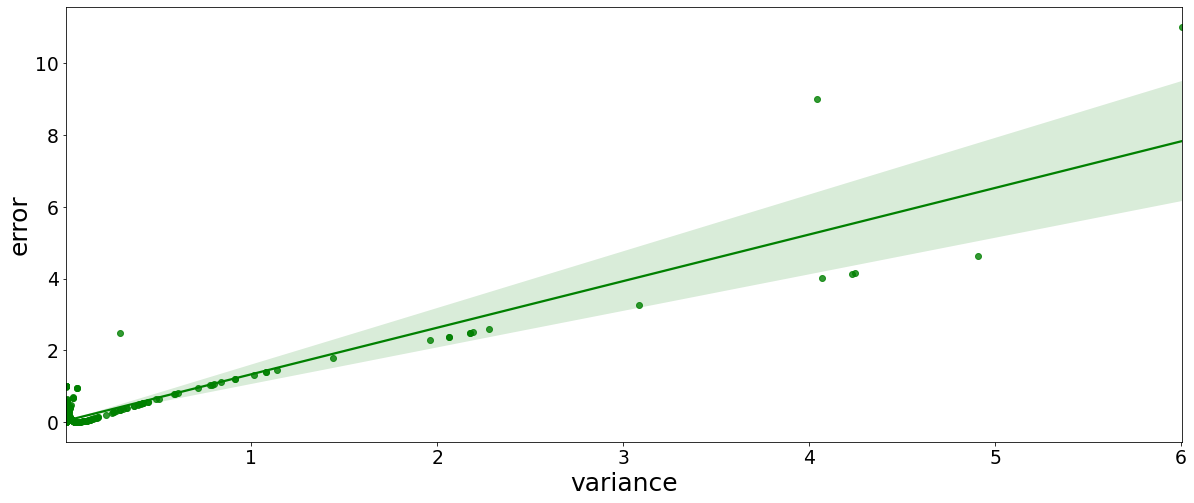

In [117]:
import seaborn as sns
size=25
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (20, 8),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'axes.titlepad': 25
}
plt.rcParams.update(params)

error = y_test - preds.mean().numpy().squeeze()
ax = sns.regplot(
    x=preds.variance().numpy().squeeze(),
    y=error*error,
    color='g'
)
plt.ylabel('error')
plt.xlabel('variance');